In [1]:
import os
os.chdir("/content/drive/MyDrive/DataScience/PROJECT/2022_Time_Series/time_series")

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta, time
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
with open('data/pv_imputation.pickle', 'rb') as f:
    pv = pickle.load(f)

In [4]:
pv['x_time'] = [int(i.split(' ')[1]) for i in pv['time']]

# scaling

In [5]:
from sklearn.preprocessing import MinMaxScaler

In [6]:
power_scaler = MinMaxScaler()
power_scaler.fit(pv[['power']])
pv['power_scale'] = power_scaler.transform(pv[['power']])

In [7]:
x_features = ['alt', 'azi', 'rad', 'temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wspd', 'pres', 'x_time']

x_scaler = MinMaxScaler()
x_scaler.fit(pv[x_features])
pv[x_features] = x_scaler.transform(pv[x_features])

In [9]:
# iw=ow여야 한다.
tz = timezone(timedelta(hours=-6))
pv_train = pv.loc[:datetime(2006,11,30,23,tzinfo=tz)]
pv_val = pv.loc[datetime(2006,11,30,18,tzinfo=tz):datetime(2006,12,20,23,tzinfo=tz)]
pv_test = pv.loc[datetime(2006,12,20,18,tzinfo=tz):datetime(2006,12,31,23,tzinfo=tz)]

pv_val_criterion = pv_val.loc[datetime(2006,12,1,00,tzinfo=tz):]
pv_test_criterion = pv_test.loc[datetime(2006,12,21,00,tzinfo=tz):]

In [ ]:
# iw=ow여야 한다.
tz = timezone(timedelta(hours=-6))
pv_train = pv.loc[:datetime(2006,11,30,23,tzinfo=tz)]
pv_val = pv.loc[datetime(2006,11,30,00,tzinfo=tz):datetime(2006,12,20,23,tzinfo=tz)]
pv_test = pv.loc[datetime(2006,12,20,00,tzinfo=tz):datetime(2006,12,31,23,tzinfo=tz)]

pv_val_criterion = pv_val.loc[datetime(2006,12,1,00,tzinfo=tz):]
pv_test_criterion = pv_test.loc[datetime(2006,12,21,00,tzinfo=tz):]

# data loader

- torch 에서 LSTM 의 경우 
  - input: (seq_len, batch, input_size)
  - output: (seq_len, batch, num_directions * hidden_size) 

In [10]:
from torch.utils.data import DataLoader, Dataset

In [11]:
class windowDataset(Dataset):
    def __init__(self, y, input_window, output_window, num_feature, data_comp, stride=1):
        #총 데이터의 개수
        L = y.shape[0]
        # seq_len
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output : shape = (window 크기, sample 개수)
        X = np.zeros([input_window, num_samples, num_feature])
        Y = np.zeros([output_window, num_samples, num_feature])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i,:] = y[start_x:end_x]
            # print(X.shape)

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]
            # print(Y.shape)

        X = X.reshape(X.shape[0], X.shape[1], num_feature).transpose((1,0,2)) # (seq_len, input_window, feature)
        Y = Y.reshape(Y.shape[0], Y.shape[1], num_feature).transpose((1,0,2)) # (seq_len, output_window, 1=power)

        if data_comp==1:
            Y = Y[:,:,0][:,:,None]
            print(Y.shape)

        if data_comp==2:
            X = Y[:,:,1:].copy()
            Y = Y[:,:,0][:,:,None]
            print(X.shape)
            print(Y.shape)
        
        self.x = X
        self.y = Y
        self.len = len(X)

    def __getitem__(self, i):
        return self.x[i], self.y[i]

    def __len__(self):
        return self.len

# model

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm.auto import tqdm
import random
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
class lstm(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1): # num_layers: lstm layer 수
        super(lstm, self).__init__() 
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # batch_first=True 인 경우 (batch, input_window, feature) 에 맞춰서 input
        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True, bidirectional=True) 
        self.linear = nn.Linear(self.hidden_size*2, 1)

    def forward(self, x):
        output, hidden = self.lstm(x)
        out = self.linear(output)
        return out

# Train

In [14]:
def train(model, train_loader, optimizer, criterion, device='cuda'):
    model.train()
    total_loss = 0.0

    for x, y in train_loader:
        optimizer.zero_grad()
        x = x.to(device).float()
        y = y.to(device).float()

        output = model(x).to(device)

        # print(f"x shape: {x.shape}")
        # print(f"y shape: {y.shape}")
        # print(f"pred shape: {output.shape}")
        # print(f"final y shape: {y[:,:,0].shape}")
        # print(f"final pred shape: {output[:,:,0].shape}")

        loss = criterion(output[:,-stride:,0], y[:,-stride:,0])
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=3)
        optimizer.step()
        total_loss += loss.cpu().item()

    train_loss = total_loss/len(train_loader)
    
    return output.detach().cpu().numpy(), y.detach().cpu().numpy(), train_loss

def predict(model, test_loader, criterion, device='cuda', file_name=None):
    model.eval()

    total_loss = 0.0
    outputs = []
    ys = []

    for t, (x, y) in enumerate(test_loader):
        # print(t)
        x = x.to(device).float()
        y = y.to(device).float()

        with torch.no_grad():
            output = model(x).to(device)
        # print(output.shape)
        # outputs[t,:,:,:] = output
        outputs.append(list(output.detach().cpu().numpy()))
        ys.append(list(y.detach().cpu().numpy()))
        loss = criterion(output[:,-stride:,0], y[:,-stride:,0])
        total_loss += loss.cpu().item()

    test_loss = total_loss/len(test_loader)

    if file_name:
        torch.save(model.state_dict(), file_name)

    return np.array(sum(outputs,[])), np.array(sum(ys,[])), test_loss

In [16]:
iw = 6
ow = 6
stride = 6
num_feature = len(x_features)+1

train_dataset = windowDataset(pv_train[['power_scale']+x_features], 
                              input_window=iw, output_window=ow, num_feature=num_feature, data_comp=1, stride=stride)
valid_dataset = windowDataset(pv_val[['power_scale']+x_features], 
                             input_window=iw, output_window=ow, num_feature=num_feature, data_comp=1, stride=stride)
test_dataset = windowDataset(pv_test[['power_scale']+x_features], 
                             input_window=iw, output_window=ow, num_feature=num_feature, data_comp=1, stride=stride)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

(1335, 6, 1)
(80, 6, 1)
(44, 6, 1)


In [17]:
a = next(iter(train_loader))
print(a[0].shape)
print(a[1].shape)

torch.Size([64, 6, 12])
torch.Size([64, 6, 1])


In [18]:
param_config = {
    "learning_rate": 0.001,
    "epochs": 1000,
    "input_size": len(x_features)+1,
    "hidden_size": 20
}

In [19]:
device='cuda'
model = lstm(input_size=param_config['input_size'], hidden_size=param_config['hidden_size']).to(device)

learning_rate=param_config['learning_rate']
epoch = param_config['epochs']
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

In [20]:
# 파라미터 수 계산
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 5,481 trainable parameters


In [21]:
# wandb.watch(model, log='all', log_freq=10)

val_loss_min = 100
file_name = 'model/basic.model'

pbar = tqdm(range(param_config['epochs']))
for epoch in pbar:
    *result_train, train_loss = train(model, train_loader, optimizer, criterion, device=device)
    *result_val, val_loss = predict(model, val_loader, criterion, device=device)
    *result_test, test_loss = predict(model, test_loader, criterion, device=device)

    if val_loss < val_loss_min:
        val_loss_min = val_loss
        torch.save(model.state_dict(), file_name)
        print(f"epoch: {epoch} / val_loss: {val_loss:.5f} / test_loss: {test_loss:.5f}")

    # wandb.log({"train_loss": train_loss, "val_loss": val_loss, "test_loss": test_loss, "val_loss_min": val_loss_min})

    pbar.set_postfix(loss=f"train_loss: {train_loss:.5f} / val_loss: {val_loss:.5f} / test_loss: {test_loss:.5f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 0 / val_loss: 0.08289 / test_loss: 0.04455
epoch: 1 / val_loss: 0.06966 / test_loss: 0.04819
epoch: 2 / val_loss: 0.05580 / test_loss: 0.03742
epoch: 3 / val_loss: 0.04148 / test_loss: 0.03489
epoch: 4 / val_loss: 0.03169 / test_loss: 0.03646
epoch: 5 / val_loss: 0.02450 / test_loss: 0.03269
epoch: 6 / val_loss: 0.02035 / test_loss: 0.03046
epoch: 7 / val_loss: 0.01886 / test_loss: 0.03061
epoch: 8 / val_loss: 0.01488 / test_loss: 0.02565
epoch: 10 / val_loss: 0.01304 / test_loss: 0.02384
epoch: 11 / val_loss: 0.01264 / test_loss: 0.02280
epoch: 30 / val_loss: 0.01216 / test_loss: 0.02132
epoch: 45 / val_loss: 0.01176 / test_loss: 0.01948
epoch: 50 / val_loss: 0.01166 / test_loss: 0.01895
epoch: 55 / val_loss: 0.01129 / test_loss: 0.01732
epoch: 185 / val_loss: 0.01116 / test_loss: 0.01360


# result

In [22]:
pred_val = result_val[0]
pred_val = power_scaler.inverse_transform(pred_val[:,-stride:,0].reshape(-1,1))
print(f"pred_val: {len(pred_val)}")

pred_test = result_test[0]
pred_test = power_scaler.inverse_transform(pred_test[:,-stride:,0].reshape(-1,1))
print(f"pred_test: {len(pred_test)}")

pv_val_criterion['pred'] = pred_val.reshape(-1)
pv_test_criterion['pred'] = pred_test.reshape(-1)

pred_val: 480
pred_test: 264


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

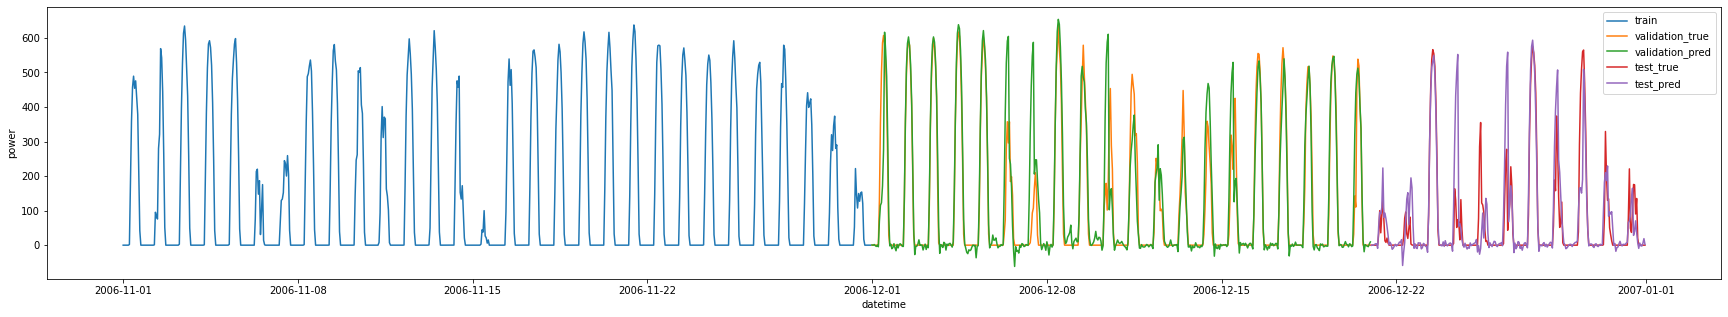

In [23]:
plt.figure(figsize=(30,5))

sns.lineplot(pv_train.loc[datetime(2006,11,1,00,tzinfo=tz):].index, pv_train.loc[datetime(2006,11,1,00,tzinfo=tz):]['power'], label='train')
sns.lineplot(pv_val_criterion.index, pv_val_criterion['power'], label='validation_true')
sns.lineplot(pv_val_criterion.index, pv_val_criterion['pred'], label='validation_pred')
sns.lineplot(pv_test_criterion.index, pv_test_criterion['power'], label='test_true')
sns.lineplot(pv_test_criterion.index, pv_test_criterion['pred'], label='test_pred')
plt.legend()

In [24]:
print(f"validation RMSE: {mean_squared_error(pv_val_criterion['power'], pv_val_criterion['pred'])**0.5:.5f}")
print(f"validation R2: {r2_score(pv_val_criterion['power'], pv_val_criterion['pred']):.5f}")

print(f"test RMSE: {mean_squared_error(pv_test_criterion['power'], pv_test_criterion['pred'])**0.5:.5f}")
print(f"test R2: {r2_score(pv_test_criterion['power'], pv_test_criterion['pred']):.5f}")

validation RMSE: 85.94261
validation R2: 0.79420
test RMSE: 88.32982
test R2: 0.59562


In [25]:
model.load_state_dict(torch.load(file_name))
*result_val, val_loss = predict(model, val_loader, criterion, device=device)
*result_test, test_loss = predict(model, test_loader, criterion, device=device)

In [26]:
pred_val = result_val[0]
pred_val = power_scaler.inverse_transform(pred_val[:,-stride:,0].reshape(-1,1))
print(f"pred_val: {len(pred_val)}")

pred_test = result_test[0]
pred_test = power_scaler.inverse_transform(pred_test[:,-stride:,0].reshape(-1,1))
print(f"pred_test: {len(pred_test)}")

pv_val_criterion['pred'] = pred_val.reshape(-1)
pv_test_criterion['pred'] = pred_test.reshape(-1)

pred_val: 480
pred_test: 264


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

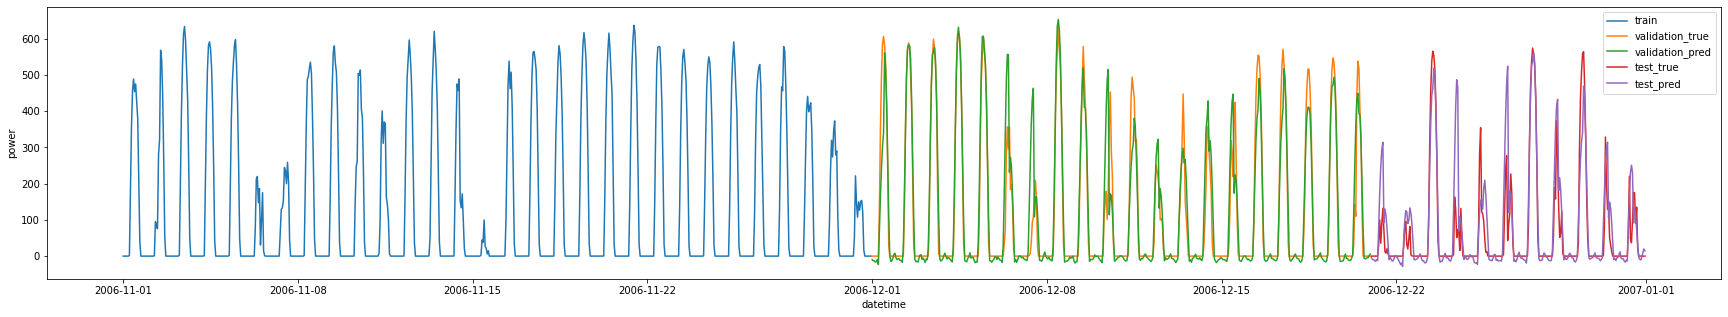

In [27]:
plt.figure(figsize=(30,5))

sns.lineplot(pv_train.loc[datetime(2006,11,1,00,tzinfo=tz):].index, pv_train.loc[datetime(2006,11,1,00,tzinfo=tz):]['power'], label='train')
sns.lineplot(pv_val_criterion.index, pv_val_criterion['power'], label='validation_true')
sns.lineplot(pv_val_criterion.index, pv_val_criterion['pred'], label='validation_pred')
sns.lineplot(pv_test_criterion.index, pv_test_criterion['power'], label='test_true')
sns.lineplot(pv_test_criterion.index, pv_test_criterion['pred'], label='test_pred')
plt.legend()

In [28]:
print(f"validation RMSE: {mean_squared_error(pv_val_criterion['power'], pv_val_criterion['pred'])**0.5:.5f}")
print(f"validation R2: {r2_score(pv_val_criterion['power'], pv_val_criterion['pred']):.5f}")

print(f"test RMSE: {mean_squared_error(pv_test_criterion['power'], pv_test_criterion['pred'])**0.5:.5f}")
print(f"test R2: {r2_score(pv_test_criterion['power'], pv_test_criterion['pred']):.5f}")

validation RMSE: 71.45613
validation R2: 0.85773
test RMSE: 79.64437
test R2: 0.67124
